In [1]:
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
mypath='/content/gdrive/MyDrive/images'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images=[]
for n in range(0, len(onlyfiles)):
    images.append(cv2.imread( join(mypath,onlyfiles[n])))


In [3]:
##UTILITY FUNCTIONS


def Rectangle(img,point,t):
    ##FUNCTION TO DRAW A RECTANGULAR SHAPE JOINING THE COORDINATES PASSED VIA THE POINT VARIABLE ON THE IMAGE WITH THE EDGES OF RECTANGLE HAVING T THICKNESS
    cv2.line(img, (point[0][0][0], point[0][0][1]), (point[1][0][0], point[1][0][1]), (255, 0, 0), t)
    cv2.line(img, (point[0][0][0], point[0][0][1]), (point[2][0][0], point[2][0][1]), (255, 0, 0), t)
    cv2.line(img, (point[3][0][0], point[3][0][1]), (point[2][0][0], point[2][0][1]), (255, 0, 0), t)
    cv2.line(img, (point[3][0][0], point[3][0][1]), (point[1][0][0], point[1][0][1]), (255, 0, 0), t)
    return img
  

def orderfinal(point):
    ##FUNCTION TO CHANGE THE ORDER OF COORDINATES OF THE POINT VARIABLE SO THAT IT CAN BE USED TO DRAW THE CONTOUR ON IMAGE 
   
    newpoint = np.ones((4, 1, 2), dtype=np.int32)
    point = point.reshape((4, 2))
    d = np.diff(point, axis=1)
    s1 = point.sum(1)
    newpoint[0] = point[np.argmin(s1)]
    newpoint[3] = point[np.argmax(s1)]
    newpoint[1] =point[np.argmin(d)]
    newpoint[2] = point[np.argmax(d)]
 
    return newpoint

def nothing(x):
    pass

 
def largestContour(contour):
    ##FUNCTION TO FIND THE LARGEST CONTOUR AND IT'S AREA FROM THE LIST OF DETECTED CONTOURS
    ar_maximum = 0
    largest = np.array([])
    for x in contour:
        ar = cv2.contourArea(x)
        if ar > 50:
            perimeter = cv2.arcLength(x, True)
            approximate = cv2.approxPolyDP(x, 0.02 * perimeter, True)
            if len(approximate) == 4 and ar > ar_maximum :
                largest = approximate
                ar_maximum = ar
    return largest,ar_maximum


In [4]:
img=[]
Canny=[]
LargeContour=[]
Adthresh=[]
kernel = np.ones((5, 5))
width  = 480
height = 640

for i in range(0, len(images)):
  imgC = images[i].copy() 
  imgLargeC = images[i].copy() 
  img=cv2.resize(images[i], (width, height)) #resizing images
  imgGray = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY) #converting to grayscale
  imgBlur = cv2.GaussianBlur(imgGray,(5,5),1 ) #gaussian blur addition 
  imgCanny = cv2.Canny(imgBlur,100,100) # finding edges using Canny Algorithm
  imgDil = cv2.dilate(imgCanny, kernel, iterations=2) # dilation 
  imgCanny = cv2.erode(imgDil, kernel, iterations=1)  # erosion
  Canny.append(imgCanny)
  contours, hierarchy = cv2.findContours(imgCanny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #contour detection
  cv2.drawContours(imgC, contours, -1, (255, 0, 0), 10) 
  large, maxArea = largestContour(contours) # finding the largest countour using utility function
  if large.size != 0:
      large=orderfinal(large)
      cv2.drawContours(imgLargeC, large, -1, (255, 0, 0), 20) # drawing the largest contour
      imgLargeC = Rectangle(imgLargeC,large,2)
      pt1 = np.float32(large) 
      pt2 = np.float32([[0, 0],[width, 0], [0, height],[width, height]]) 
      pers_matrix = cv2.getPerspectiveTransform(pt1, pt2)
      imgWarpColored1 = cv2.warpPerspective(images[i], pers_matrix, (width, height)) #warp perspective to remove skewness
      imgWarpColored=imgWarpColored1[20:imgWarpColored1.shape[0] - 20, 20:imgWarpColored1.shape[1] - 20]
      imgWarpGray = cv2.cvtColor(imgWarpColored,cv2.COLOR_BGR2GRAY)
      imgAdThresh= cv2.adaptiveThreshold(imgWarpGray, 255, 1, 1, 7, 2) #application of adaptive thresholding
      imgAdThresh = cv2.bitwise_not(imgAdThresh) #bitwise not - used to flip pixels
      imgAdThresh=cv2.medianBlur(imgAdThresh,3)  #median blur using 3x3 kernel
      imgAdThresh = cv2.resize(imgAdThresh,(imgCanny.shape[1],imgCanny.shape[0]))
      LargeContour.append(imgLargeC)
      Adthresh.append(imgAdThresh)

l=len(Adthresh)
for i in range(l):
  Adthresh[i] = cv2.cvtColor(Adthresh[i],cv2.COLOR_GRAY2BGR)
  Canny[i] = cv2.cvtColor(Canny[i],cv2.COLOR_GRAY2BGR)

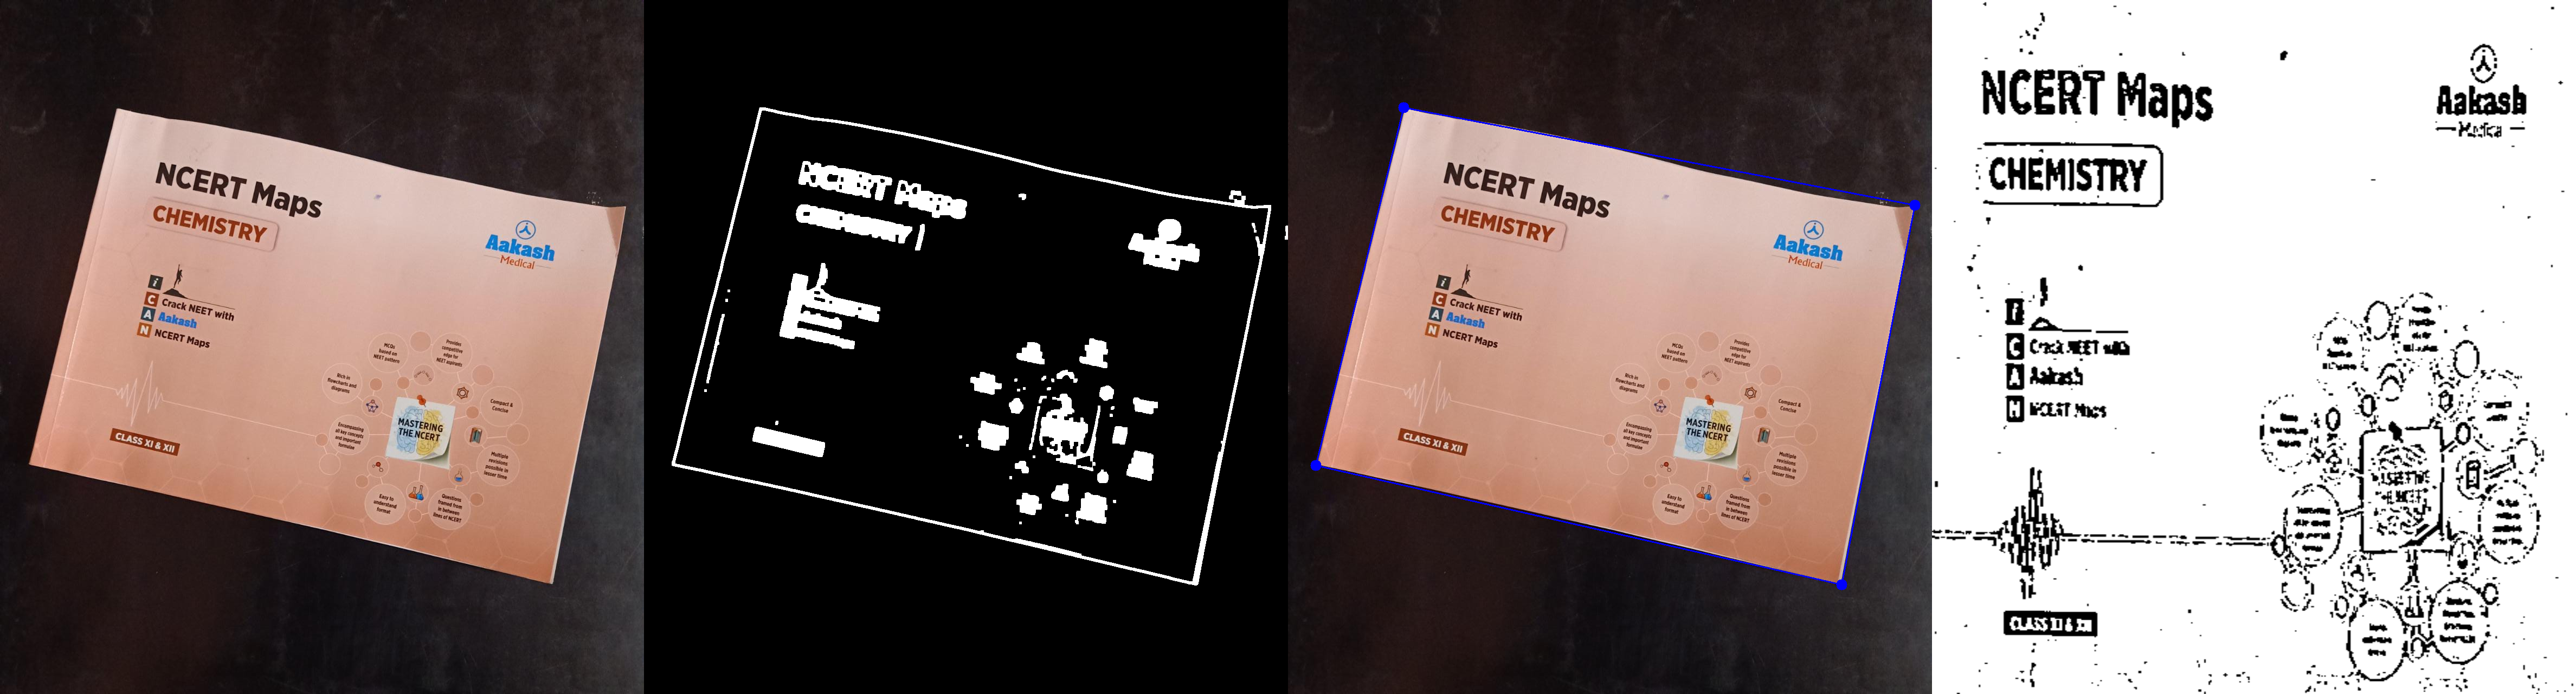

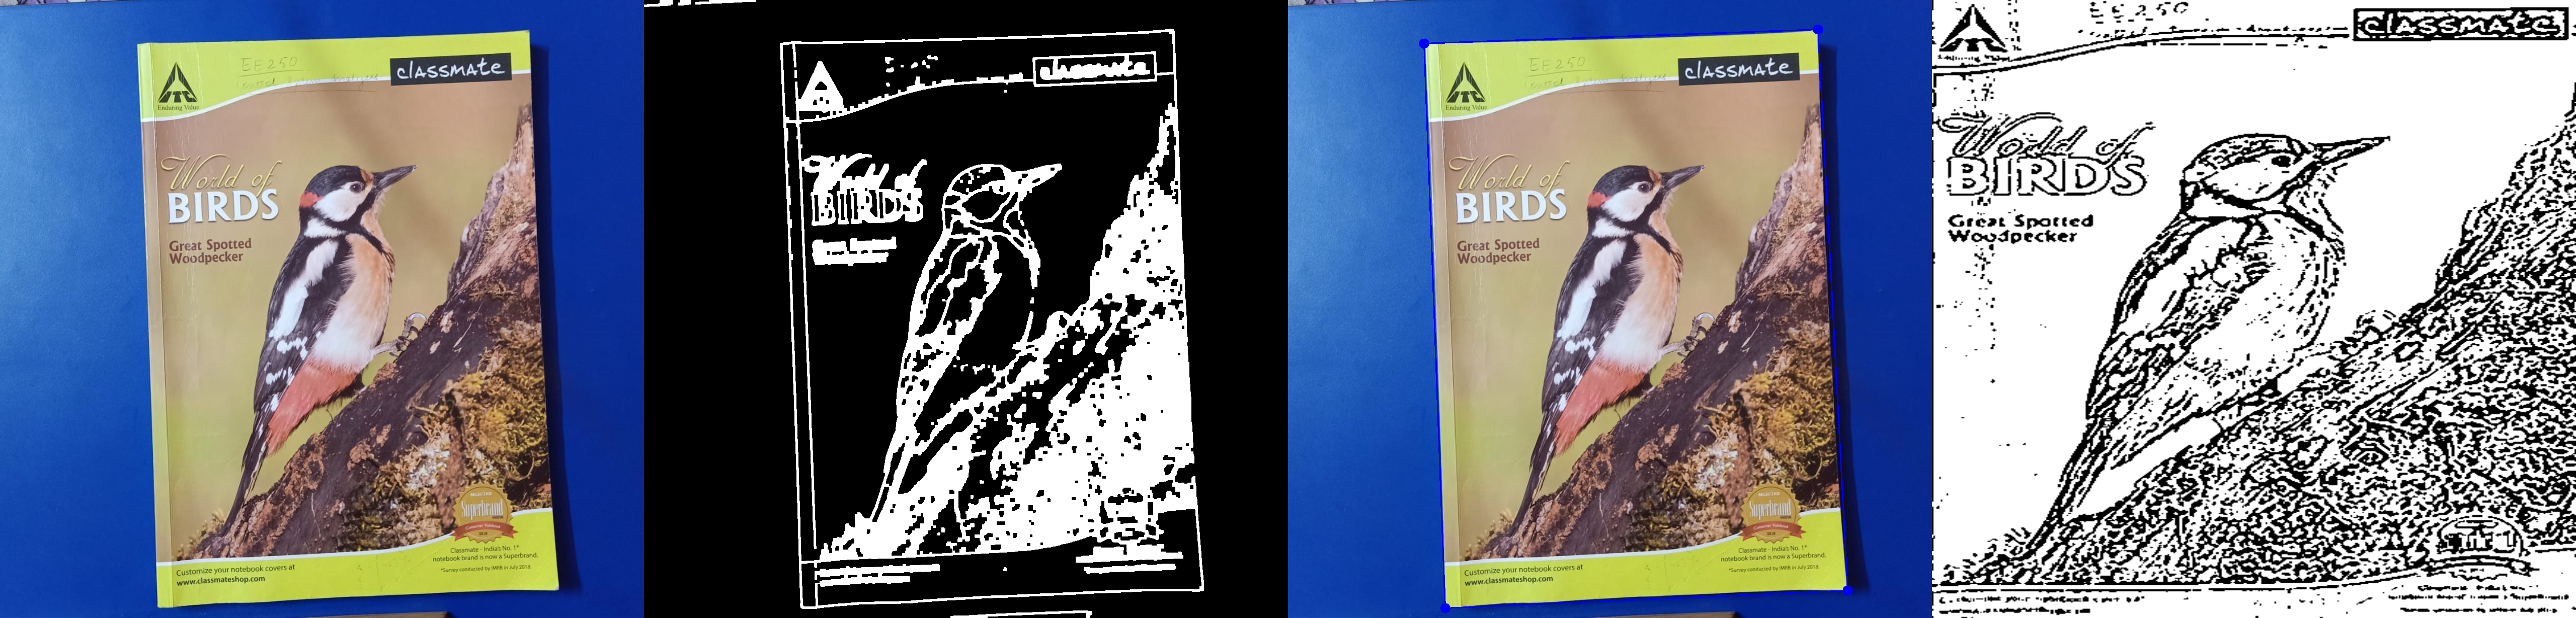

In [5]:
finlist=[]
for i in range(l):
    row = np.concatenate((images[i],Canny[i],LargeContour[i],Adthresh[i] ), axis=1)
    finlist.append(row)
    cv2_imshow(row) 